# RPN的实现

### RPN的网络实现
RPN的框架：
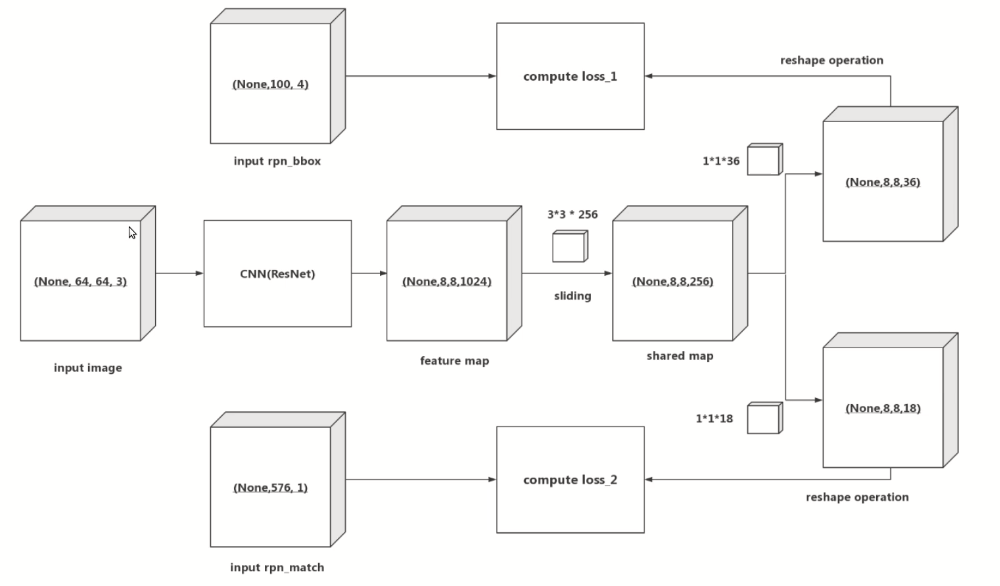
* 图解
    * 上支路是所有anchor的修正量（4\*9）
    * 下支路是前景背景9个anchor的分类得分(前景 背景)

* rpn_match
    * label为1的anchor： 当一个anchor与真实bounding box的最大IOU超过阈值Vt1(0.7)
    * label为-1的anchor ： 当一个anchor与真实bounding box的最大IOU低于阈值Vt2(0.3)
    * label为0的anchor ： 当一个anchor与真实bounding box的最大IOU介于Vt2与Vt1之间
    * Negative anchor 与 Positive anchor 的数量之和是一个人为设置的常数

* rpn_bbox
    * Input_rpn_bbox 是anchor和真实bbox之间的偏移量，RPN网络计算的也是偏移量!
    * 只有positive anchor才有对应的Input_rpn_bbox 

ResNet
* block
    * 保证跳远连接层和最后一层输入层的长宽以及通道数一样，可以实现相加操作
    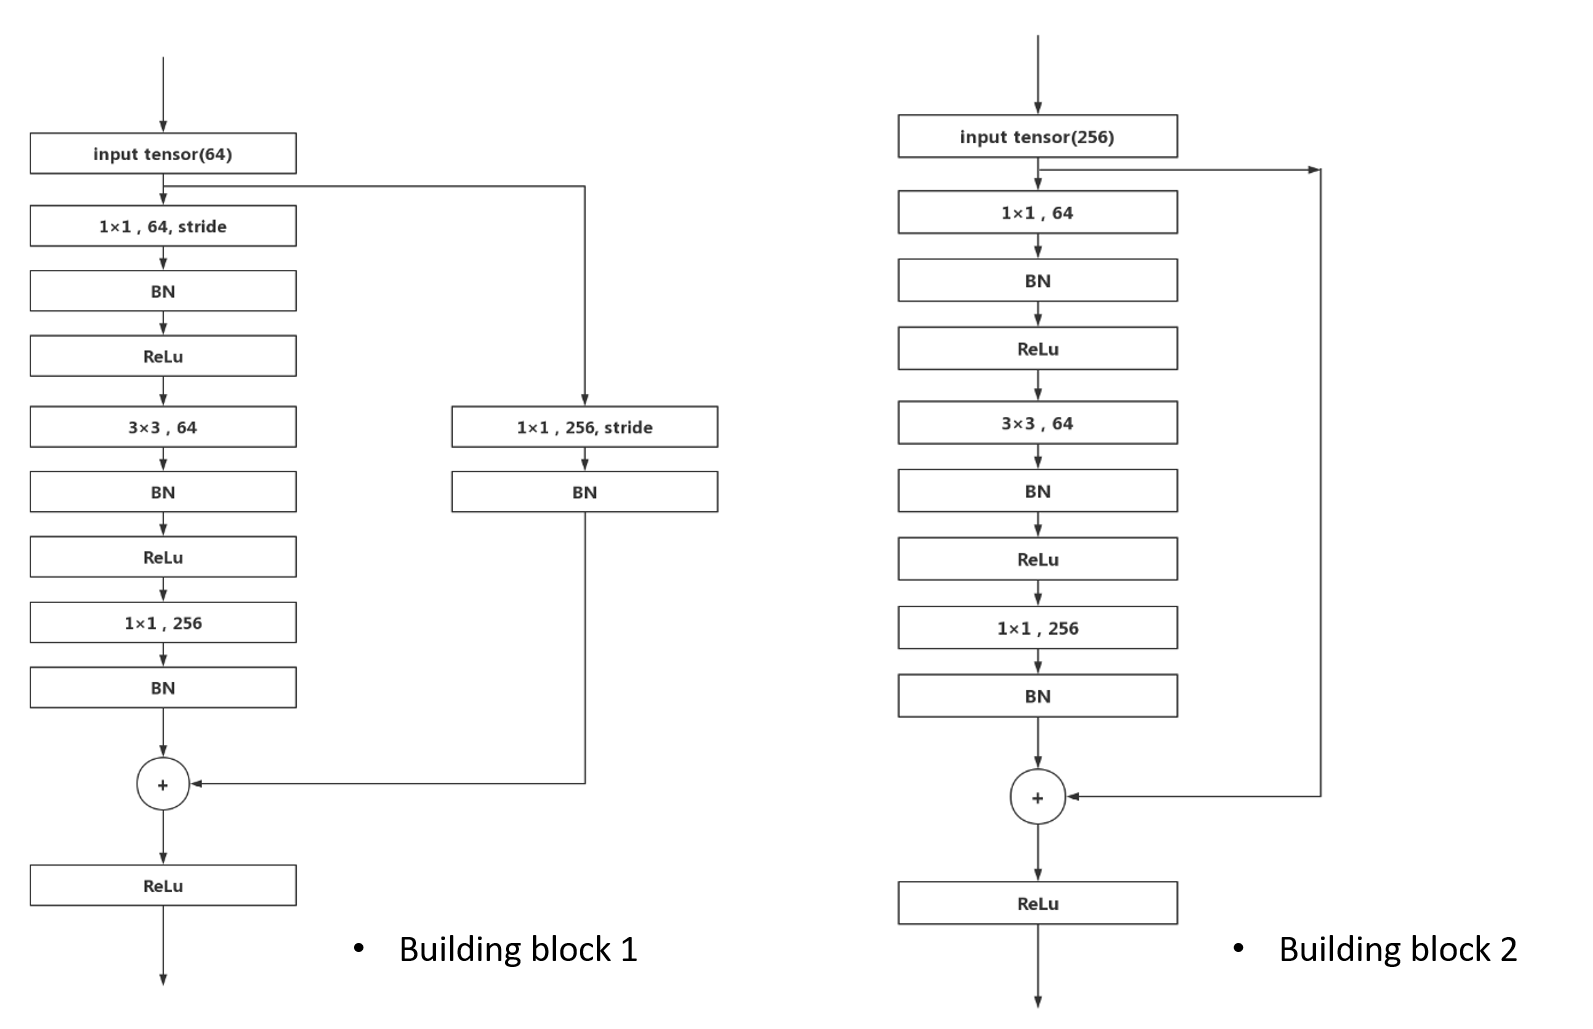
* 架构
    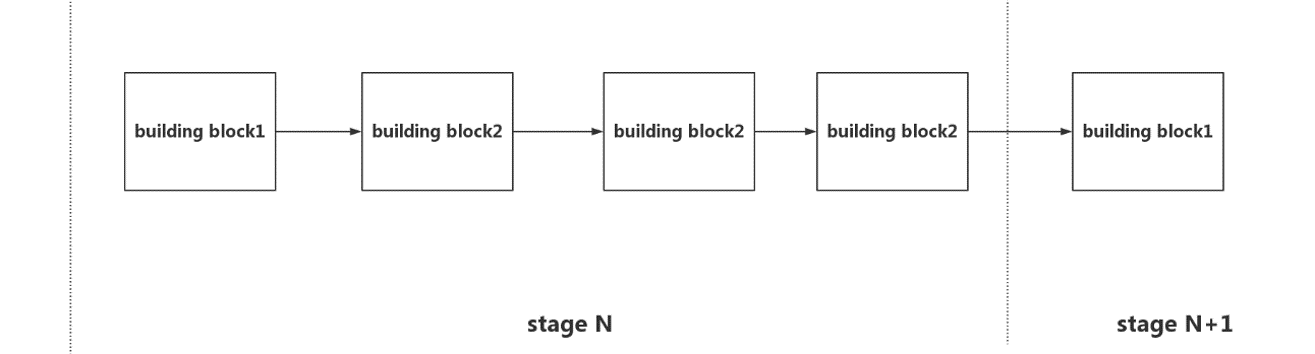

In [1]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


构建block

In [2]:
def building_block(filters,block):
    if block !=0 :
        stride=1
    else:
        stride=2
    
    def f(x):
        # 主通路
        y=KL.Conv2D(filters,(1,1),strides=stride)(x)
        y=KL.BatchNormalization(axis=3)(y)
        y=KL.Activation("relu")(y)
        
        y=KL.Conv2D(filters,(3,3),padding="same")(y)
        y=KL.BatchNormalization(axis=3)(y)
        y=KL.Activation("relu")(y)
        
        y=KL.Conv2D(4*filters,(1,1))(y)
        y=KL.BatchNormalization(axis=3)(y)
        
        
        if block==0 :
            shortcut=KL.Conv2D(4*filters,(1,1),strides=stride)(x)
            shortcut=KL.BatchNormalization(axis=3)(shortcut)
        else:
            shortcut=x
            
        y=KL.Add()([y,shortcut])
        y=KL.Activation("relu")(y)
        
        return y
    return f

构建resnet

In [3]:
def resNet_featureExtractor(inputs):
    x=KL.Conv2D(64,(3,3),padding="same")(inputs)
    x=KL.BatchNormalization(axis=3)(x)
    x=KL.Activation("relu")(x)
    
    filters=64
    
    # 每一个stage的block的个数  每个stage中 第一个block是block1 其他的是block2
    blocks=[2]
    #  blocks=[3,6,4]
    for i,block_num in enumerate(blocks):
        for block_id in range(block_num):
            x=building_block(filters,block_id)(x)
        filters *=2
    return x
        

In [4]:
x=KL.Input((64,64,3))
y=resNet_featureExtractor(x)
res_model=Model([x],[y])
# model.summary()

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(res_model,to_file="images/res_model.png",show_shapes=True)

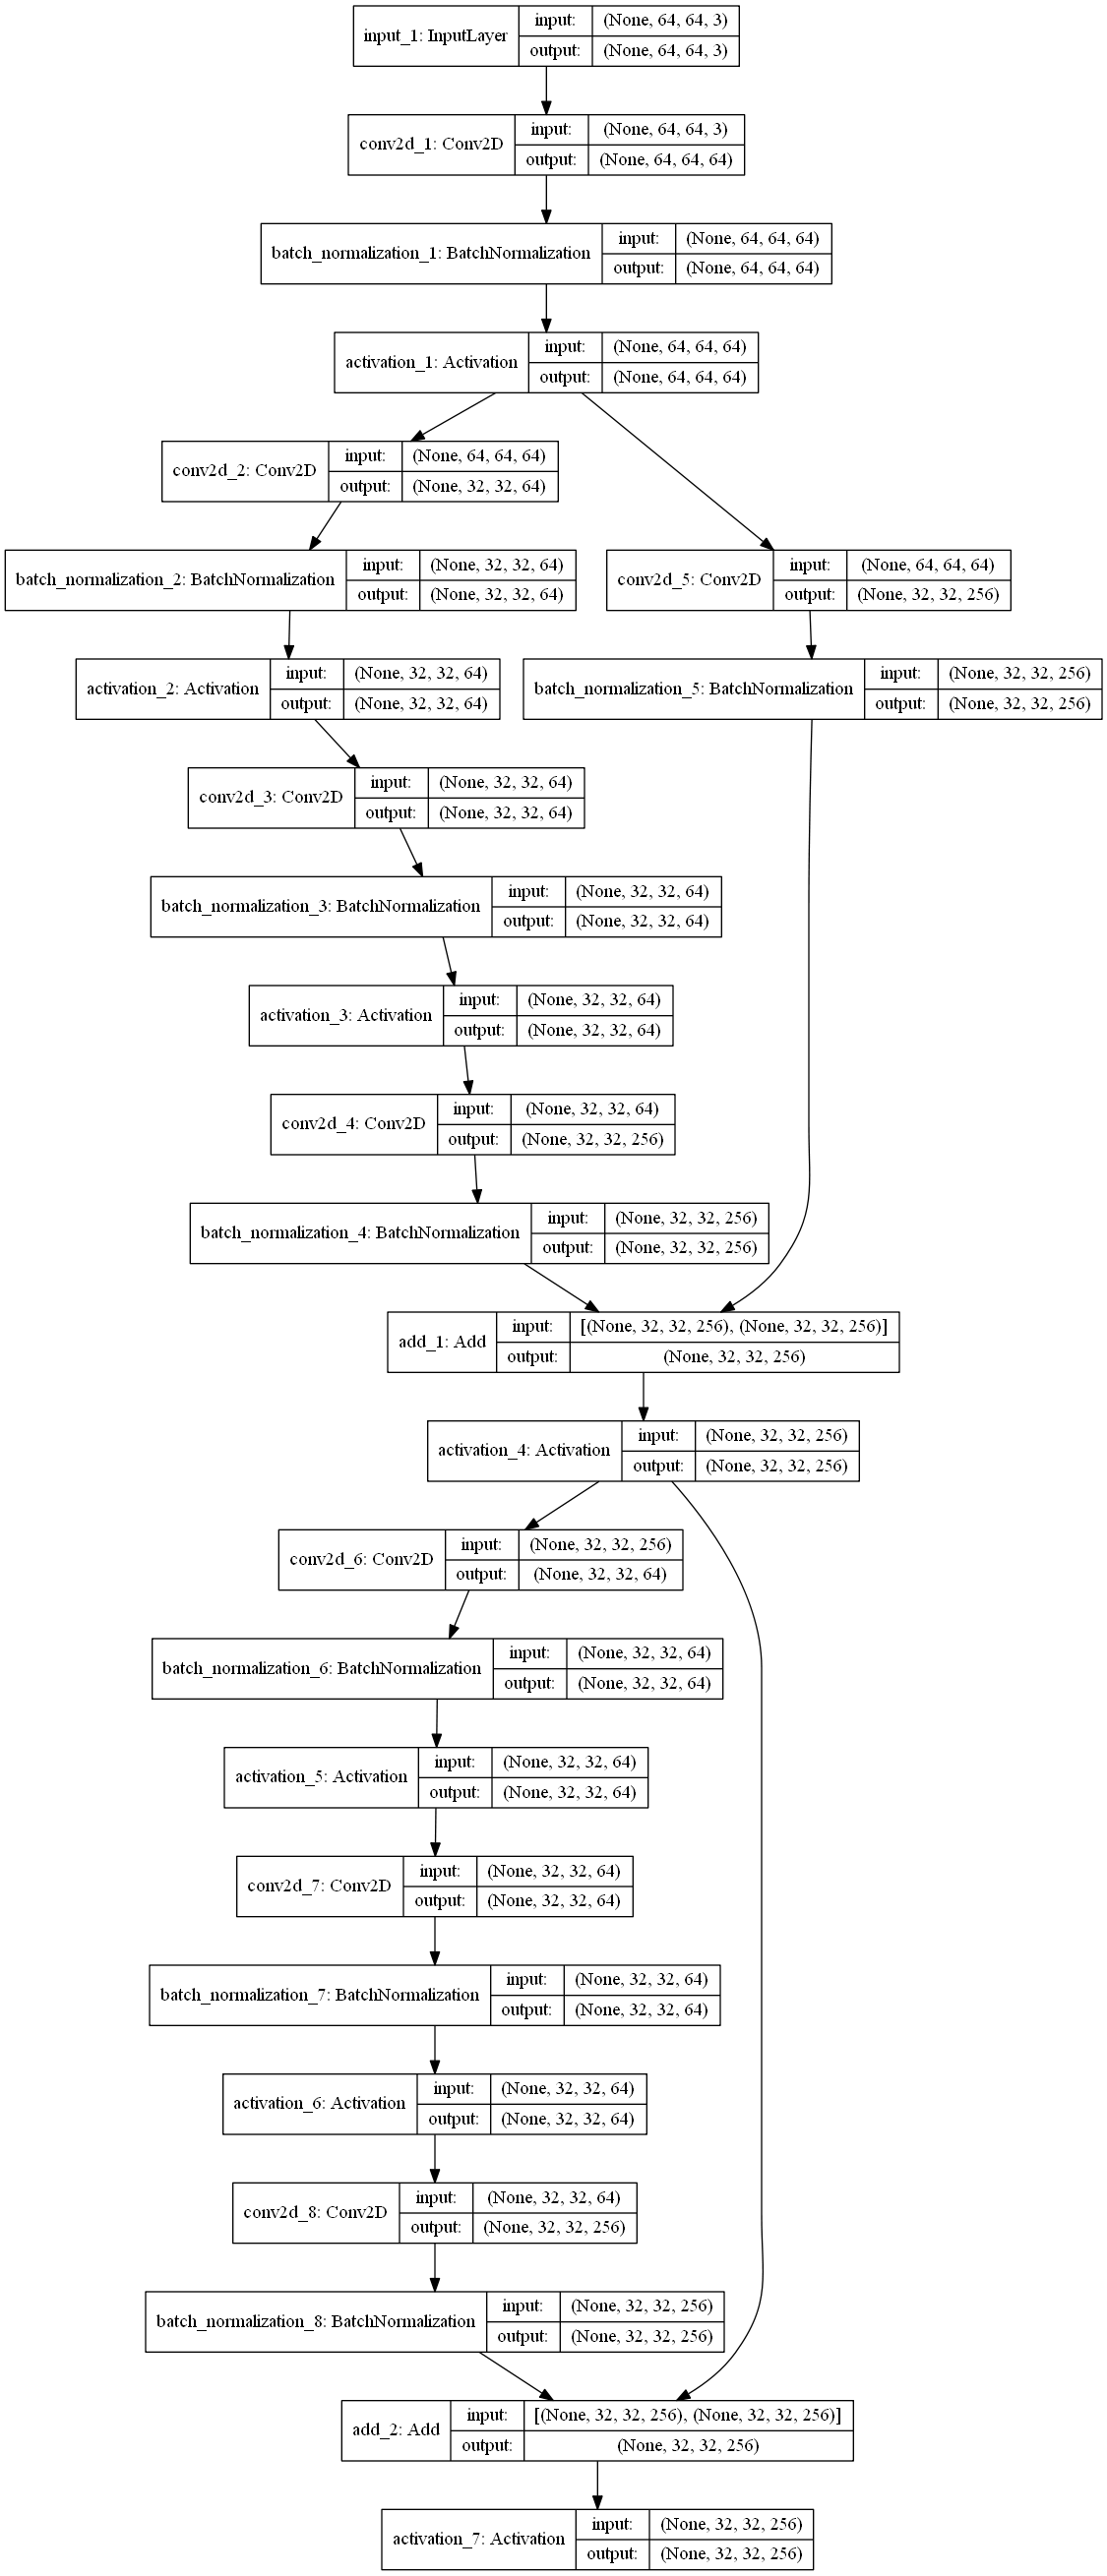

CNN网络构建完成后，实现后续rpn

In [6]:
def rpn_net(inputs,k):
    shared_map=KL.Conv2D(256,(3,3),padding="same")(inputs)
    shared_map=KL.Activation("linear")(shared_map)
    
    # 下支路
    rpn_class=KL.Conv2D(2*k,(1,1))(shared_map)
    rpn_class=KL.Lambda(lambda x:tf.reshape(x,[tf.shape(rpn_class)[0],-1,2]))(rpn_class)
    rpn_class=KL.Activation("linear")(rpn_class)
    rpn_prob=KL.Activation("softmax")(rpn_class)
    
    
    #上支路
    y=KL.Conv2D(4*k,(1,1))(shared_map)
    y=KL.Activation("linear")(y)
    rpn_bbox=KL.Lambda(lambda x:tf.reshape(x,[tf.shape(x)[0],-1,4]))(y)
    
    return rpn_class,rpn_prob,rpn_bbox

In [7]:
x=KL.Input((64,64,3))
fp=resNet_featureExtractor(x)
rpn_class,rpn_prob,rpn_bbox=rpn_net(fp,9)
rpn_model=Model([x],[rpn_class,rpn_prob,rpn_bbox])
# rpn_model.summary()

In [10]:
plot_model(rpn_model,to_file="images/rpn_model.png",show_shapes=True)

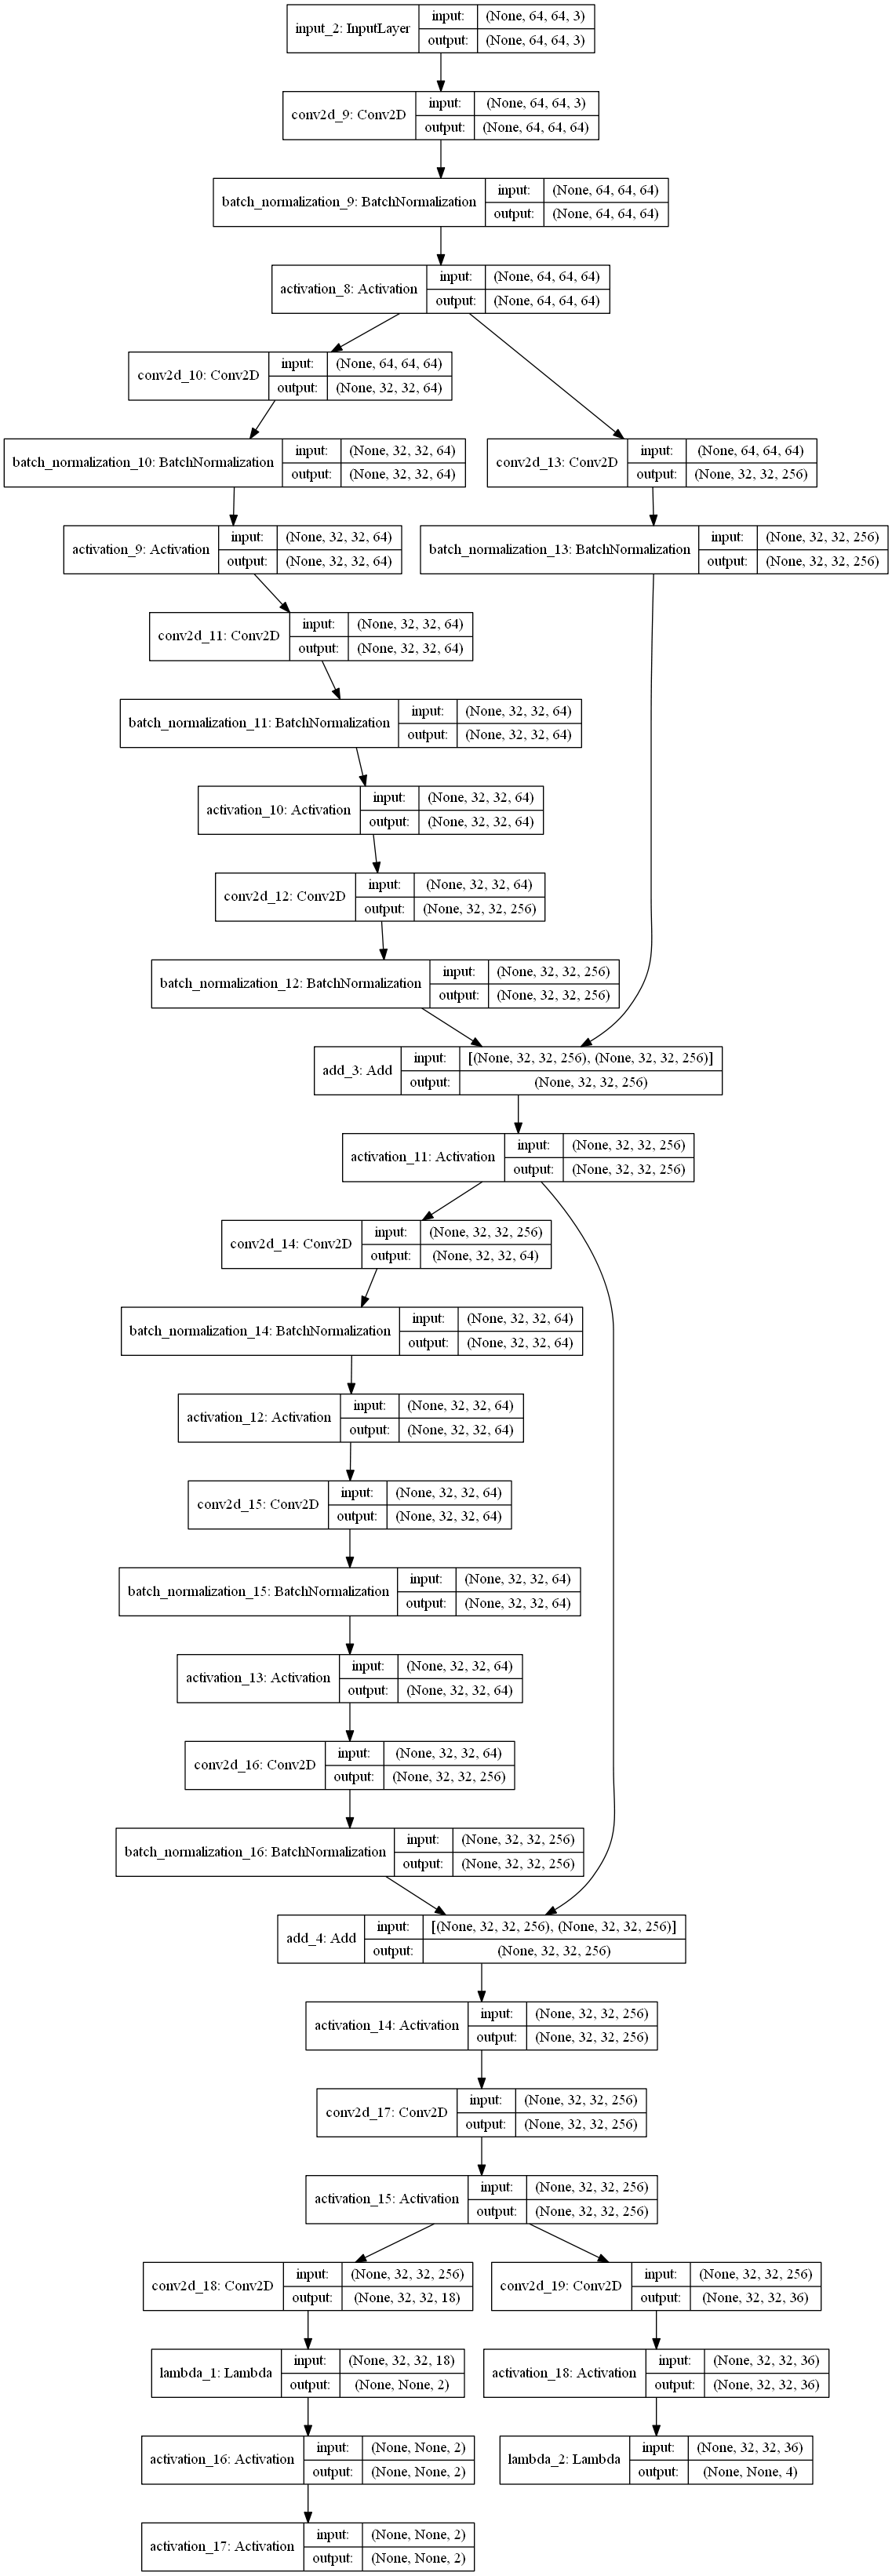

### RPN的loss实现

RPN loss:

$RPNLoss=Classification Loss + Bounding Box Loss$

Classification Loss(分类损失)：
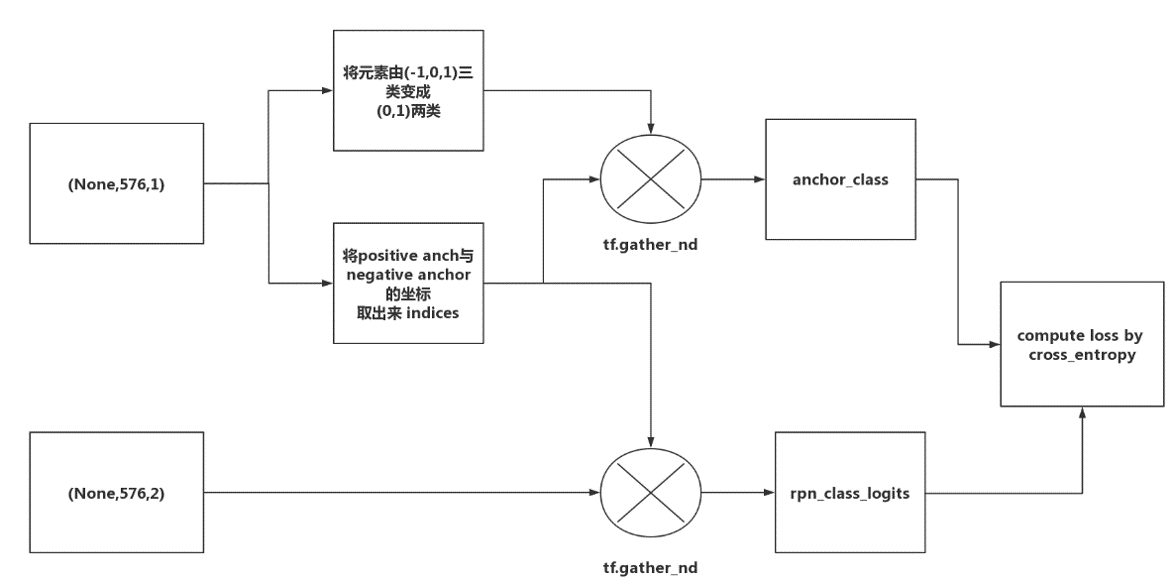

$Classification Loss=cross\_entropy(anchor\_class,rpn\_class\_logits)$


* input_rpn_match(None, 576,1)是实际值  rpn_class_logits(None, 576,2)是RPN网络的输出
* 先取出input_rpn_match中正负anchor的坐标
* 再将input_rpn_match中label为(0,-1)的统一变为0
* 按正负anchor的坐标对input_rpn_match，rpn_class_logits取值，进行回归

In [11]:
def rpn_class_loss(input_rpn_match,rpn_class_logits):
    
    ## input_rpn_match(None,576,1)  8*8*9 个label  每个label有三种取值（-1,0,1）
    ## rpn_class_logits(None, 576,2)  RPN网络的输出 8*8*9*2
    
    # rpn_match(None,576,1)变成 (None,576)
    input_rpn_match=tf.squeeze(input_rpn_match,-1)
    
    # 取出 -1和1 两类label 的坐标
    indices=tf.where(K.not_equal(input_rpn_match,0))
    
    # label 为1的还是1   lable为（-1,0）的都变为0
    anchor_class=K.cast(K.equal(input_rpn_match,1),tf.int32)
    
    # 按坐标取元素
    anchor_class=tf.gather_nd(anchor_class,indices)         ##target    (None,1)
    rpn_class_logits=tf.gather_nd(rpn_class_logits,indices) ##prediction  (None,2)
    
    
    
    loss=K.sparse_categorical_crossentropy(target=anchor_class,output=rpn_class_logits,from_logits=True)
    loss=K.switch(tf.size(loss)>0,K.mean(loss),tf.constant(0.0))
    
    return loss
    

Bounding Box Loss Loss(回归损失)：

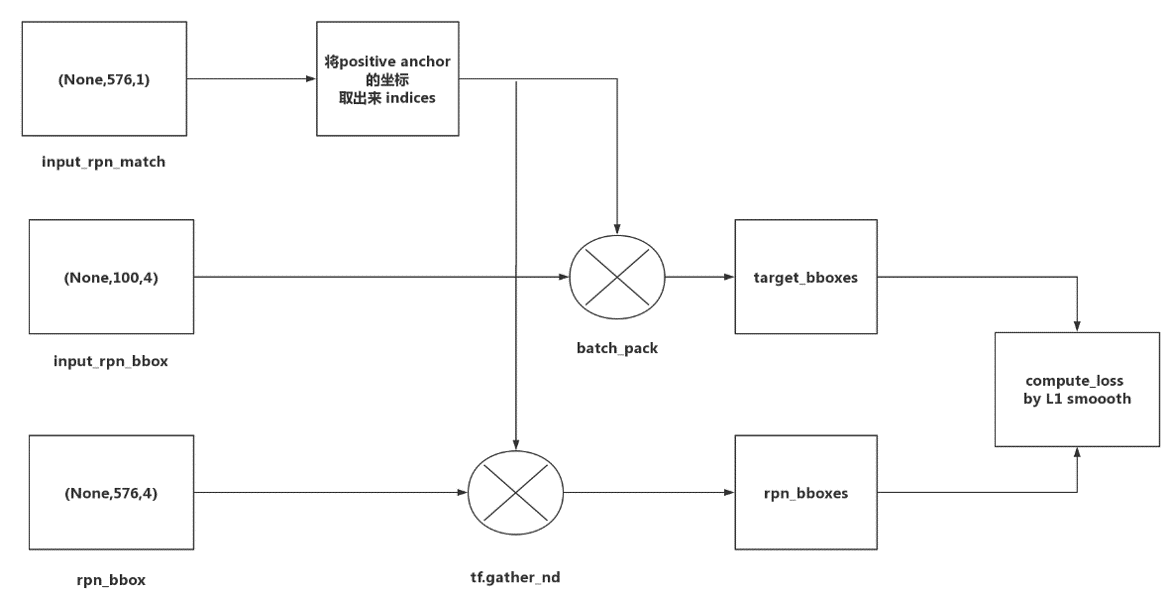


* rpn_bbox(None,576,4) 为rpn网络的实际计算结果
* input_rpn_bbox(None,100,4)  target，正anchor的修正量
* input_rpn_match(None,576,1) target，anchor的label
* 只回归正anchor 
* 在input_rpn_match(None,576,1)的anchor中 把label是1的anchor坐标取出来
* 根据坐标把rpn_bbox中的结果取出来 作为预测值 prediction
* 通过batch pack把input_rpn_bbox和正label匹配起来
* 根据坐标损失函数需要用L1 smooth（一定范围内用平方和，超过范围使用直线），因为使用简单的平方差，当bbox与真实值相差过大，损失函数会大幅上升，这样在优化损失函数的时候，会着重优化那些偏差比较大的bbox(避免偏差越大越敏感)

小工具  batch  pack

In [12]:
def batch_pack(x,counts,num_rows):
    outputs=[]
    for i in range(num_rows):
        outputs.append(x[i,:counts[i]])
    return tf.concat(outputs,axis=0)

In [13]:
def rpn_bbox_loss(input_rpn_bbox,input_rpn_match,rpn_bbox):
    ## input_rpn_bbox(None,100,4)  
    ## input_rpn_match(None,576,1)
    ## rpn_bbox(None,576,4)
    
    
    #压缩rpn_match(None,576,1) -> (None,576) 
    input_rpn_match=tf.squeeze(input_rpn_match,-1)
    # 获得正anchor的坐标
    indices=tf.where(K.equal(input_rpn_match,1))
    # 根据坐标把rpn_bbox中的结果取出来 作为预测值 prediction
    rpn_bbox=tf.gather_nd(rpn_bbox,indices)
    
    
    batch_counts=K.sum(K.cast(K.equal(input_rpn_match,1),tf.int32),axis=1)
    input_rpn_bbox=batch_pack(input_rpn_bbox,batch_counts,20)
    
    #L1 loss
    diff=K.abs(input_rpn_bbox-rpn_bbox)
    less_than_one=K.cast(K.less(diff,1.0),"float32")
    loss=0.5*less_than_one*diff**2+(1-less_than_one)*(diff-0.5)
    loss=K.switch(tf.size(loss)>0,K.mean(loss),tf.constant(0.0))
    
    return loss

将loss添加进网络

In [14]:
# 输入的图片
input_image=KL.Input(shape=[64,64,3],dtype=tf.float32)
#输入的ground truth  真实的bbox
input_bboxes=KL.Input(shape=[None,4],dtype=tf.float32)

#目标的类别  RPN的实现部分暂时用不到
input_class_ids=KL.Input(shape=[None],dtype=tf.int32)

#target，anchor的label
input_rpn_match=KL.Input(shape=[None,1],dtype=tf.int32)
#target，正anchor的修正量
input_rpn_bbox=KL.Input(shape=[None,4],dtype=tf.float32)

In [15]:
feature_map=resNet_featureExtractor(input_image)
rpn_class_logits,rpn_prob,rpn_bbox=rpn_net(feature_map,9)

#添加 loss 层
loss_rpn_match=KL.Lambda(lambda x:rpn_class_loss(*x),name="loss_rpn_match")([input_rpn_match,rpn_class_logits])
loss_rpn_bbox=KL.Lambda(lambda x:rpn_bbox_loss(*x),name="loss_rpn_bbox")([input_rpn_bbox,input_rpn_match,rpn_bbox])

rpn_loss_model=Model([input_image,input_bboxes,input_class_ids,input_rpn_match,input_rpn_bbox],
            [rpn_class_logits,rpn_prob,rpn_bbox,loss_rpn_match,loss_rpn_bbox])

In [16]:
plot_model(rpn_loss_model,to_file="images/rpn_loss_model.png",show_shapes=True)

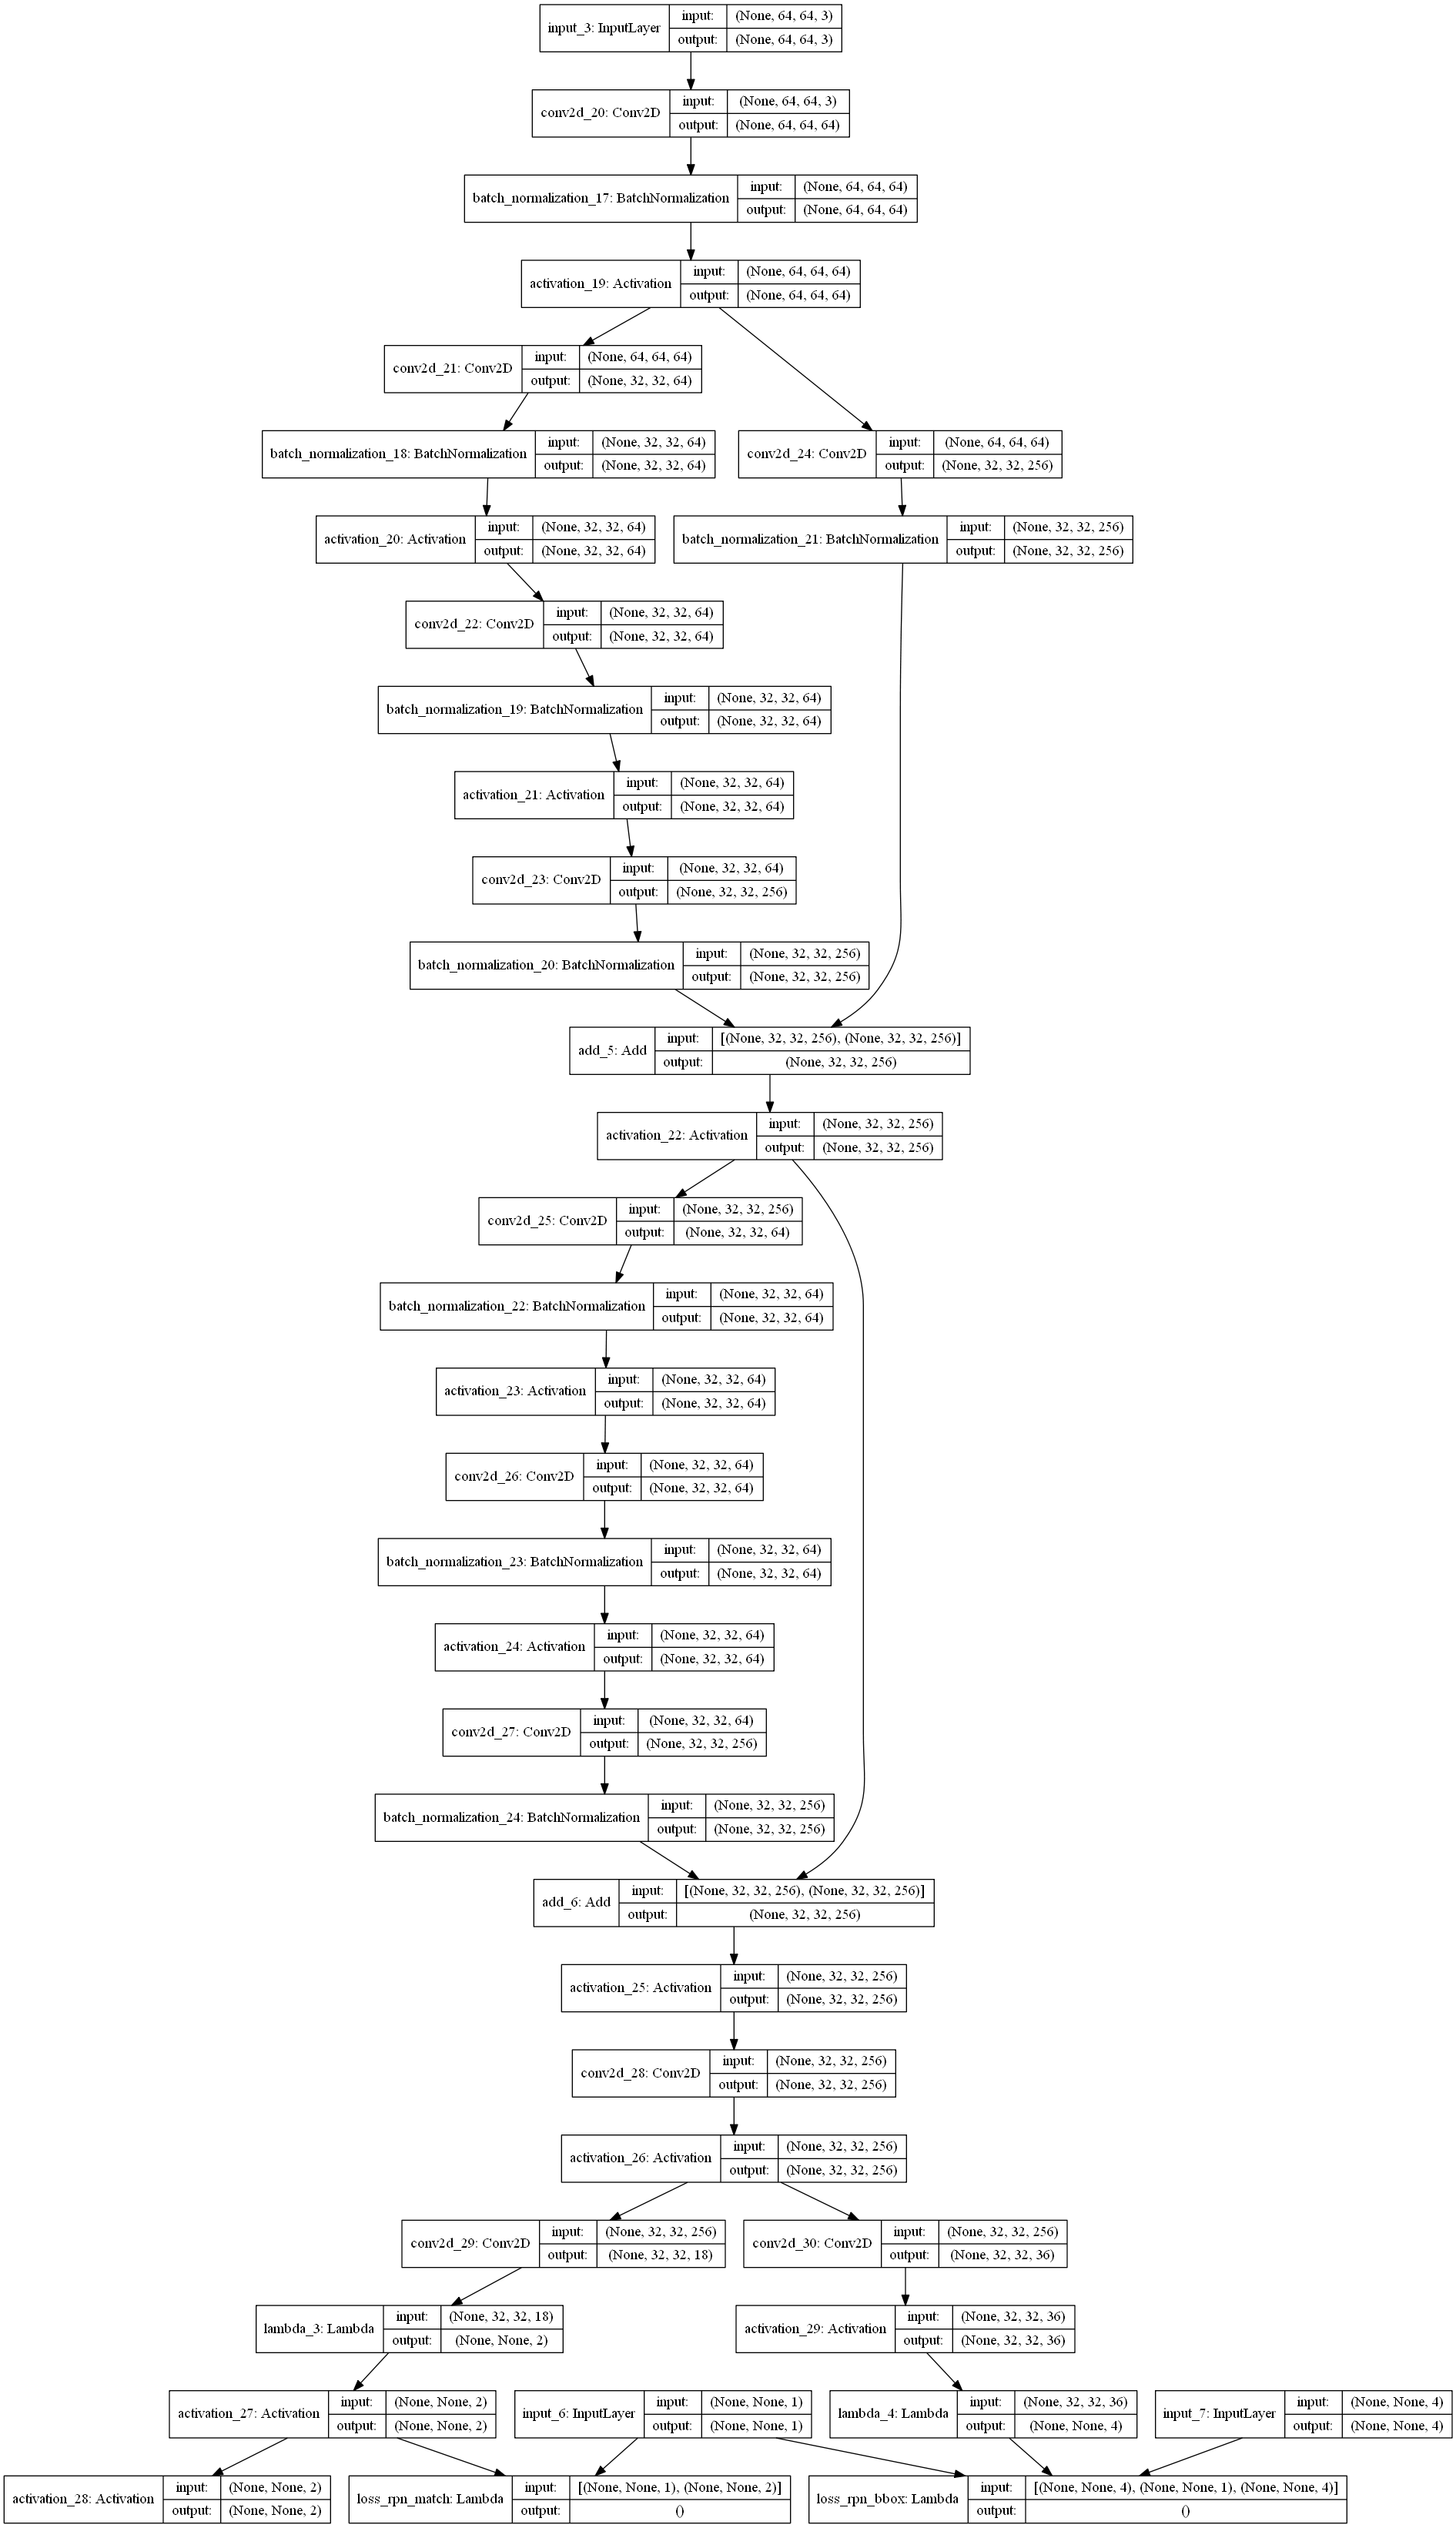

In [21]:
import keras
loss_layer1=rpn_loss_model.get_layer("loss_rpn_match").output
loss_layer2=rpn_loss_model.get_layer("loss_rpn_bbox").output


rpn_loss_model.add_loss(tf.reduce_mean(loss_layer1))
rpn_loss_model.add_loss(tf.reduce_mean(loss_layer2))

rpn_loss_model.compile(loss=[None]*len(rpn_loss_model.output),optimizer=keras.optimizers.SGD(lr=0.0005,momentum=0.9))

#分别查看 各个loss的收敛情况
# rpn_loss_model.metrics_names.append("loss_rpn_match")
# rpn_loss_model.metrics_tensors(tf.reduce_mean(loss_layer1,keepdims=True))

# rpn_loss_model.metrics_names.append("loss_rpn_bbox")
# rpn_loss_model.metrics_tensors(tf.reduce_mean(loss_layer2,keepdims=True))

In [22]:
from utils import shapeData as dataSet
from config import Config

config =Config()
dataSet=dataSet([64,64],config=config)


In [23]:
dataSet

In [24]:
def data_Gen(dataset, num_batch, batch_size, config):
    for _ in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        for i in range(batch_size):
            image, bbox, class_id, rpn_match, rpn_bbox, _ = data = dataset.load_data()
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]

In [25]:
dataGen = data_Gen(dataSet, 35000, 20, config)

In [ ]:
his=rpn_loss_model.fit_generator(dataGen,steps_per_epoch=50,epochs=10)